Production Code for Bird Sounder Model
- Build the pipeline to feed in split sound files
- output a csv for model training
- write a method to run in the app that finds the peak and cuts the inputted file (possibly at a couple peaks) to a similar length clip
- use that method to test the model's accuracy against unseen recordings
- youtube videos perhaps (limit the length of the recording that can be inputted), or give a disclaimer that the first couple seconds and last couple will be but out to remoce microphone noises
- give minimum and maximum (suggested) clip lengths to the app user
- 

Additional features to try
#try cepstral coefficiesnts
#try 2nd or third peak, (how to deal with missing values?)
#band pass filter for removing low frequency noise


In [1]:
#read in the csv to pandas
import pandas as pd

#previous files 'bird_train.csv' 'bird_train_test.csv' 'brid_train (copy).csv'
filename = 'bird_train.csv'
data = pd.read_csv(filename)
#create a copy to chop off the target values
data_copy = data.copy(deep=True)
data.tail()

,peak_Hz,peak_Q,peak_mel,fourier_freq,ampmax_n3,ampmax_n2,ampmax_n1,ampmax_0,ampmax_p1,ampmax_p2,num_samples,sample_rate,species
4344,1399.658203,40,1109.080126,2026,1291.992188,1356.591797,1356.591797,1356.591797,1356.591797,1399.658203,63945,44100,Canada Goose
4345,6843.750000,69,4057.041236,10508,5601.562500,3703.125000,5039.062500,7265.625000,6585.937500,6843.750000,69600,48000,Carolina Chickadee
4346,3036.181641,54,2121.222243,4404,2971.582031,3057.714844,2627.050781,3057.714844,3079.248047,3337.646484,63945,44100,American Robin
4347,1399.658203,41,1139.455123,2114,1378.125000,1205.859375,1378.125000,1787.255859,1830.322266,1593.457031,63945,44100,American Crow
4348,6562.500000,58,2494.548689,160,3843.750000,3890.625000,3796.875000,6562.500000,6562.500000,6585.937500,69600,48000,Carolina Chickadee


In [2]:
import seaborn as sns
data.columns

Index(['peak_Hz', 'peak_Q', 'peak_mel', 'fourier_freq', 'ampmax_n3',
       'ampmax_n2', 'ampmax_n1', 'ampmax_0', 'ampmax_p1', 'ampmax_p2',
       'num_samples', 'sample_rate', 'species'],
      dtype='object')

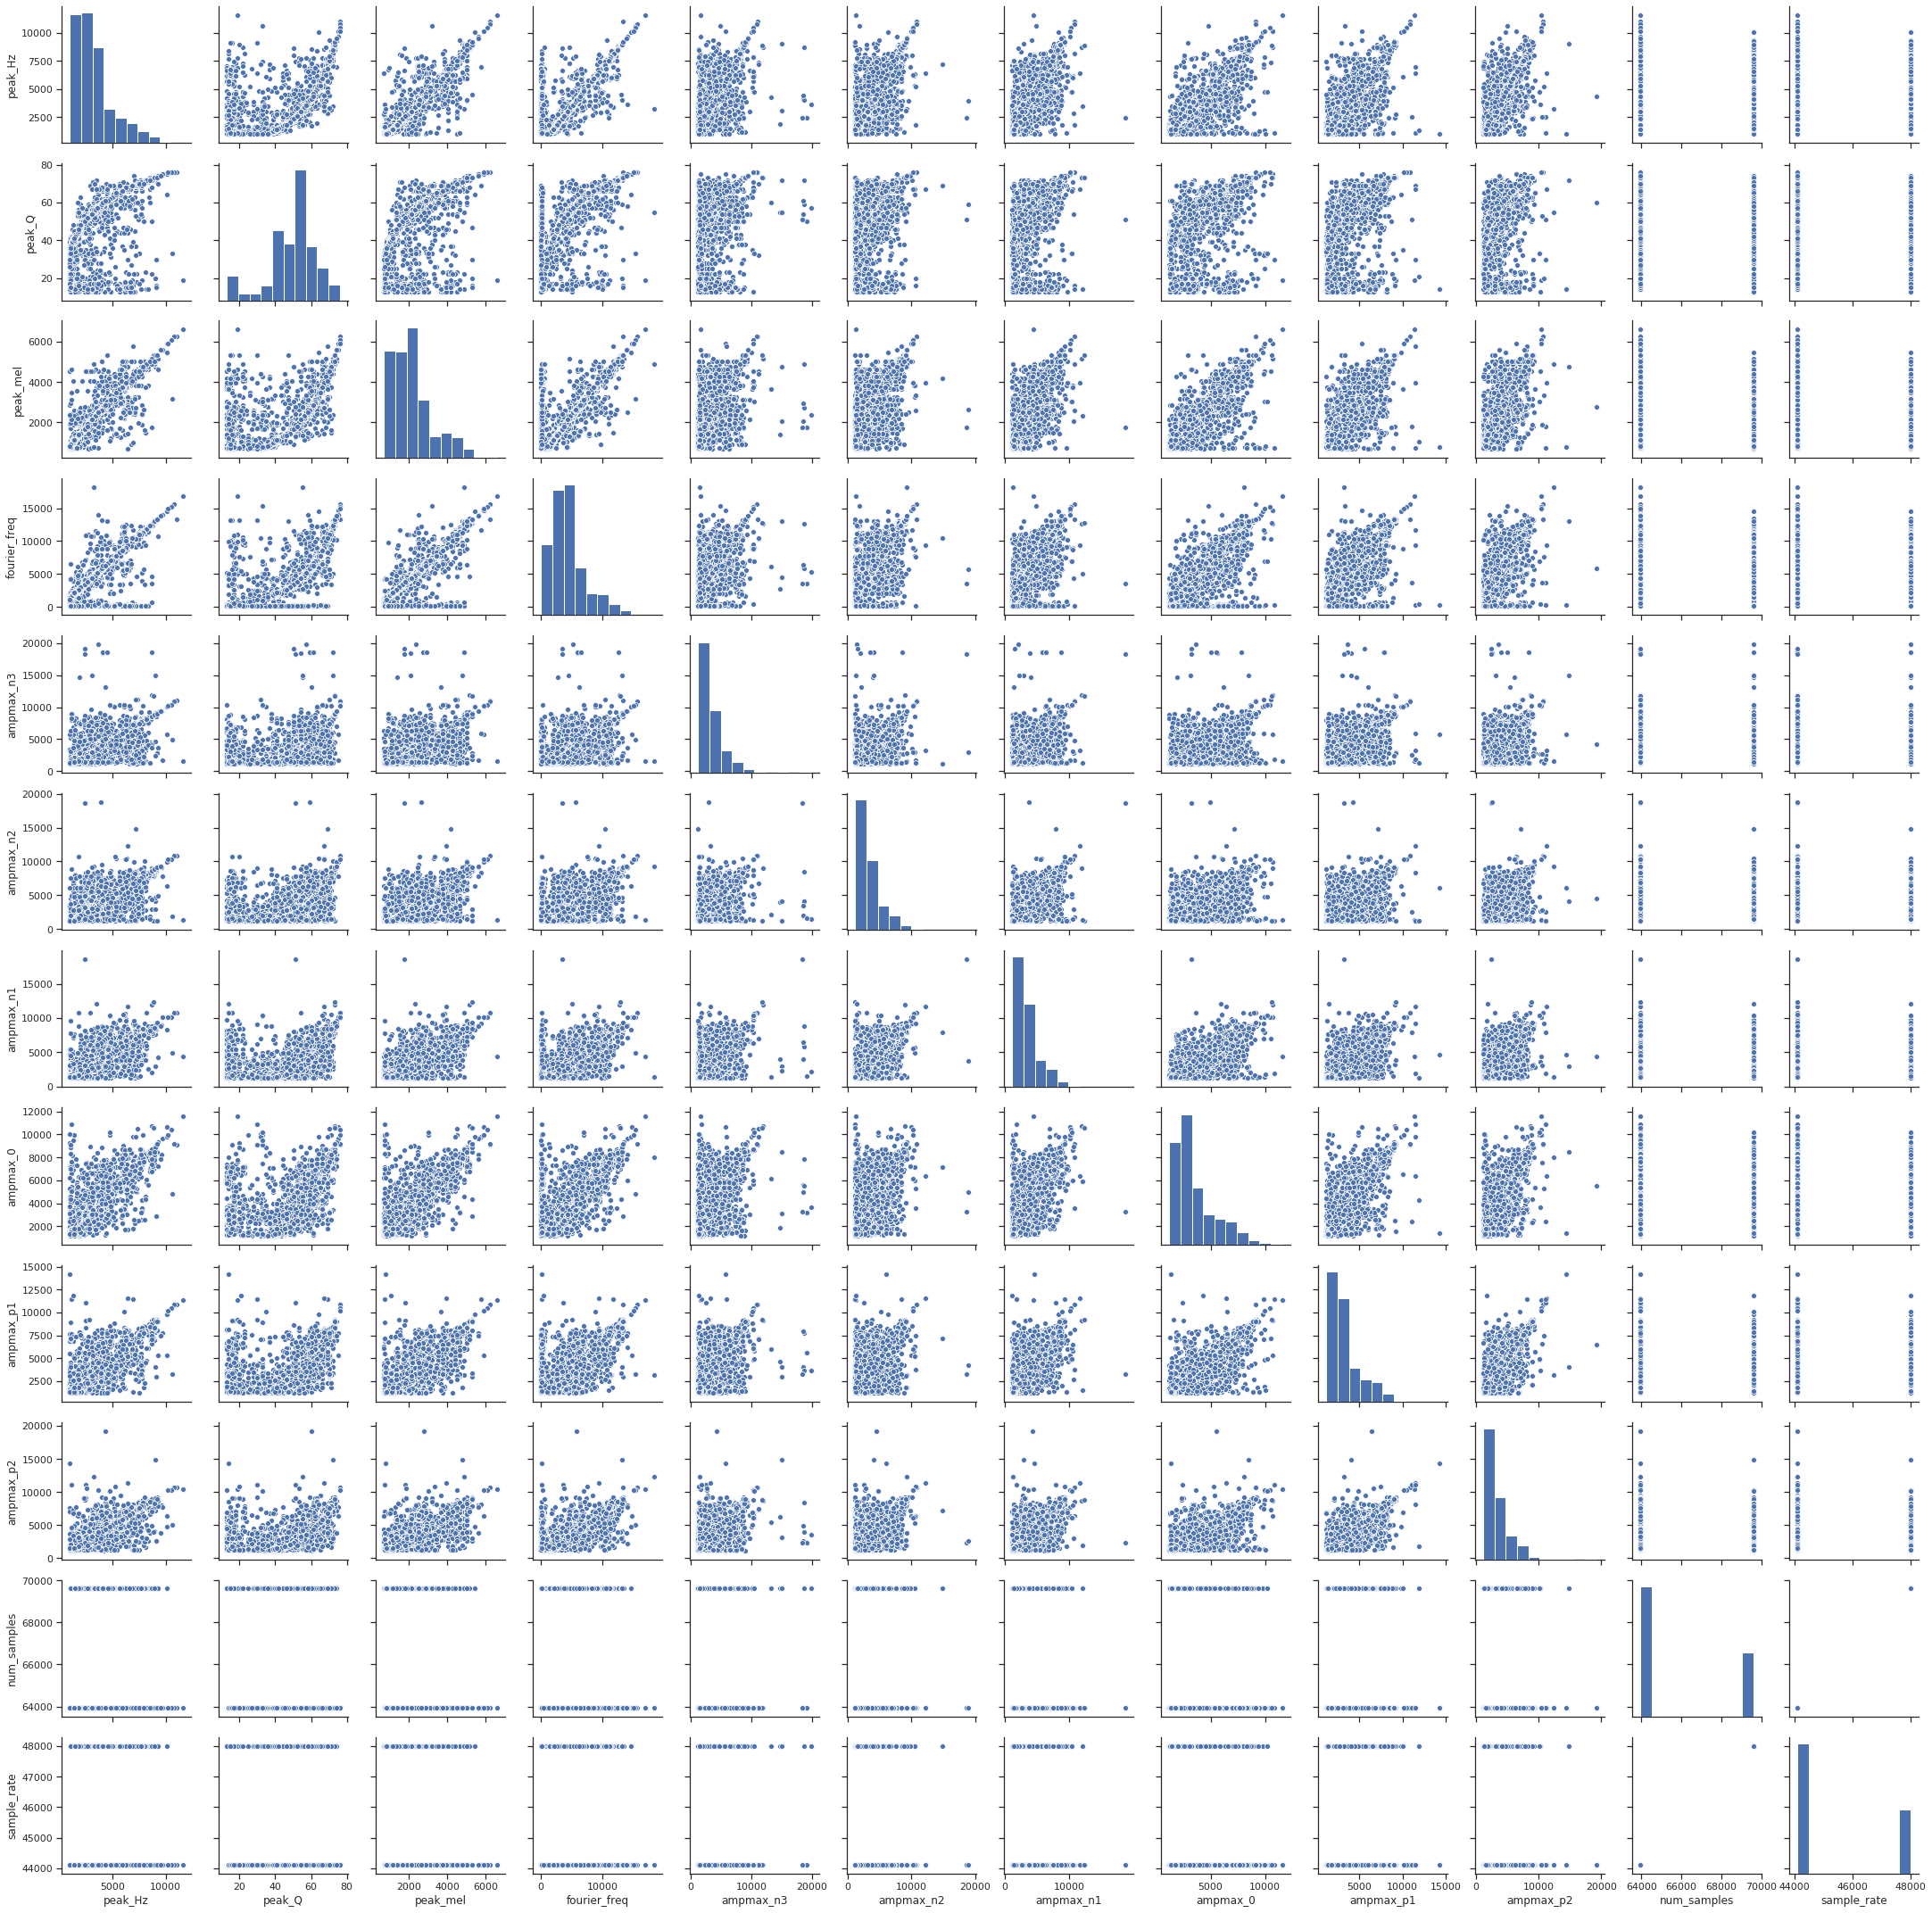

In [3]:

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data)

'0.9.0'

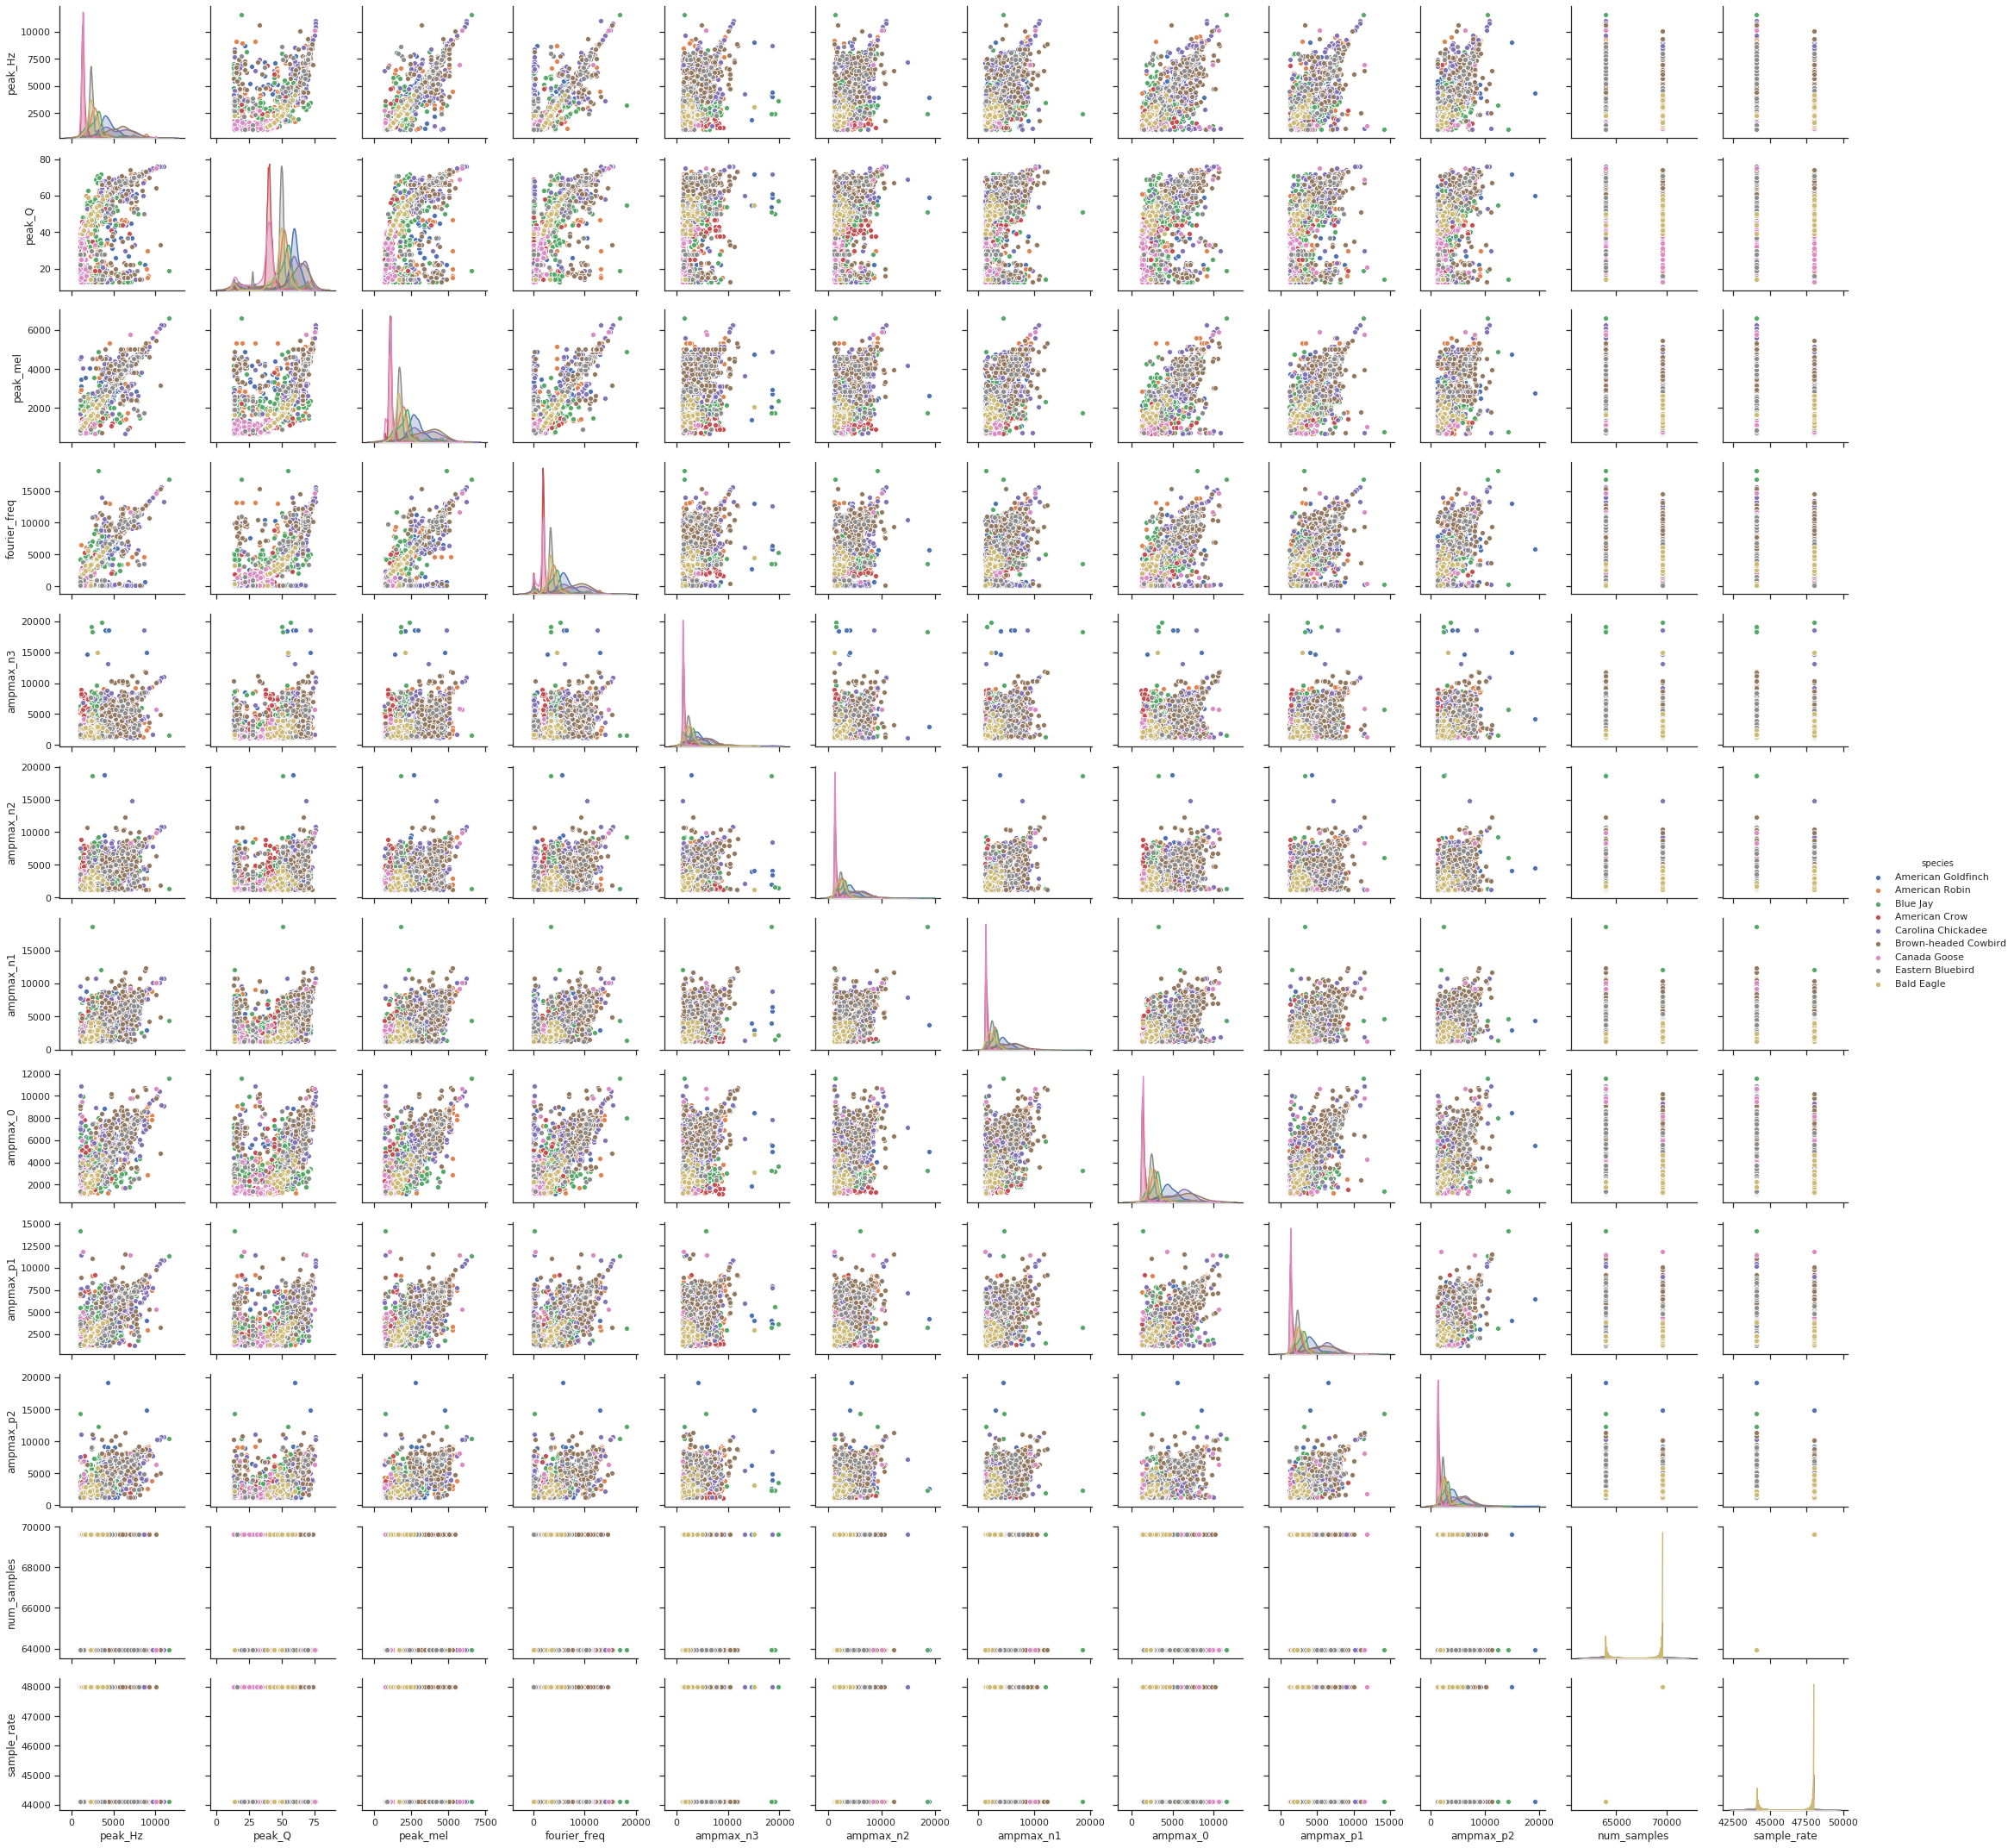

In [4]:
g = sns.pairplot(data, hue="species")
sns.__version__

Text(0.5, 1.0, 'Clip Counts per Species')

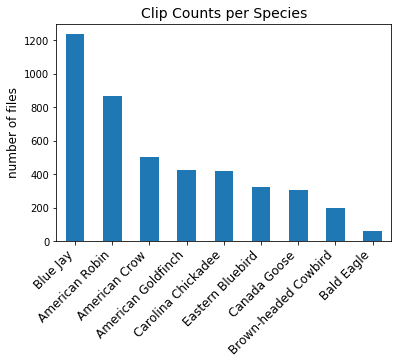

In [11]:
#data.species.plot.hist()
ax = data.species.value_counts().plot(kind='bar')
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12 )
ax.set_ylabel('number of files', fontsize=12)
ax.set_title('Clip Counts per Species', fontsize=14)

American Crow           265
Canada Goose            181
Blue Jay                 76
American Robin           23
Carolina Chickadee       19
Brown-headed Cowbird     10
Eastern Bluebird          7
American Goldfinch        5
Bald Eagle                2
Name: species, dtype: int64

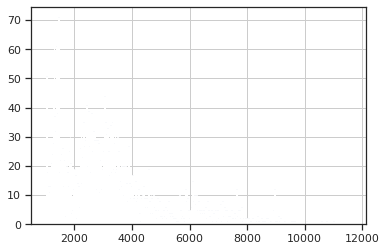

In [8]:
#check the peak frequency distribution
data.peak_Hz.hist(bins=500)
data[ data.peak_Hz < 1420 ].species.value_counts()

Series([], Name: species, dtype: int64)

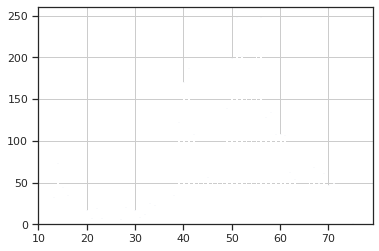

In [9]:
#check the constant Q frequency distribution
data.peak_Q.hist(bins=500)
data[ data.peak_Q < 10 ].species.value_counts()

American Crow           97
Canada Goose            91
Blue Jay                51
American Robin          25
Carolina Chickadee      18
Brown-headed Cowbird    11
Eastern Bluebird         5
American Goldfinch       2
Bald Eagle               1
Name: species, dtype: int64

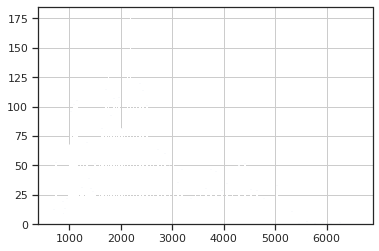

In [10]:
#check the mel frequency distribution
data.peak_mel.hist(bins=500)

data[ data.peak_mel < 1000 ].species.value_counts()

In [12]:
#use OneHot encoding to transform categorical data into something useful
from sklearn.preprocessing import OneHotEncoder
#simple imputer will handle missing values
from sklearn.impute import SimpleImputer
#chain together multiple transformations in one custom filter
from sklearn.pipeline import Pipeline
#select (by column header/key) which columns get which kind of transformation
from sklearn.compose import ColumnTransformer

In [13]:
#choose which columns get transformed
cat_cols = ['species']
#create the pipeline
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))

#combine the two transformations into a single Pipeline
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)

cat_transformers = [('cat', cat_pipe, cat_cols)]
ct = ColumnTransformer(transformers=cat_transformers)

target_fit_transformed = ct.fit_transform(data)
target_transformed = ct.transform(data) #fit shouldnt matter for one-hot encoding

pd.DataFrame( target_fit_transformed ).tail(6)

,0,1,2,3,4,5,6,7,8
4343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4344,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4346,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4347,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
#remove the species column from the test dataframe
species_col = data.pop('species')

In [15]:
#get the feature names from the transformation
all_steps = ct.named_transformers_['cat']
ohe = all_steps.named_steps['ohe']
cat_feature_names = ohe.get_feature_names()
#clean up the feature names to make more readable
ohe_column_names = [cfn.strip('x0_').strip() for cfn in cat_feature_names]
cat_feature_names, ohe_column_names 

(array(['x0_American Crow', 'x0_American Goldfinch', 'x0_American Robin',
        'x0_Bald Eagle', 'x0_Blue Jay', 'x0_Brown-headed Cowbird',
        'x0_Canada Goose', 'x0_Carolina Chickadee', 'x0_Eastern Bluebird'],
       dtype=object),
 ['American Crow',
  'American Goldfinch',
  'American Robin',
  'Bald Eagle',
  'Blue Jay',
  'Brown-headed Cowbird',
  'Canada Goose',
  'Carolina Chickadee',
  'Eastern Bluebird'])

Use stratified random sample for the test/train split
this will preserve species ratios of the data in train/test split

In [18]:
#initialize a random forest regressor model
from sklearn.ensemble import RandomForestRegressor


max_depth = 30

regr_rf = RandomForestRegressor(n_estimators=1000, max_depth=max_depth, 
                                random_state=12)#



In [19]:
#from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
from sklearn.metrics import r2_score

from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
sss = StratifiedShuffleSplit(n_splits=4, test_size=0.7, random_state=42)

#one hot encoding target
X,y = np.array(data), np.array(target_transformed)
#string target
#X,y = np.array(data), np.array(species_col)




In [20]:
for train_index, test_index in sss.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #fit the model with the new vaues
    regr_rf.fit(X_train, y_train)
    #evaluate the fit accuracy
    #print(regr_rf.score(X_test, y_test))
    y_pred = regr_rf.predict(X_test)#, y_test)#, multioutput='uniform_average')
    print( r2_score(y_test, y_pred) )

0.38596459217860907
0.36672572574888906
0.3702394958157565
0.3736696508031001


In [21]:
for feat,imp in zip(data.columns, regr_rf.feature_importances_):
    print(feat.strip(), imp)

peak_Hz 0.1421842575848403
peak_Q 0.061393069877398676
peak_mel 0.1094233338285861
fourier_freq 0.07958193026481776
ampmax_n3 0.07339595002178961
ampmax_n2 0.06447873403792961
ampmax_n1 0.0929177920268731
ampmax_0 0.14133744191445005
ampmax_p1 0.12040634585267526
ampmax_p2 0.09258735633797778
num_samples 0.01121881476888115
sample_rate 0.011074973483780568


In [19]:

regr_rf.fit(X_train, y_train)
#evaluate the fit accuracy
regr_rf.score(X_test, y_test)
#y_pred = regr_rf.predict(X_test)#, y_test)#, multioutput='uniform_average')

#r2_score(y_test, y_pred) #...          multioutput='variance_weighted')
#y_pred, y_pred.shape, y_test.shape

/home/chris/anaconda3/envs/testenv/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.4249154221970996

In [22]:
from sklearn.metrics import f1_score

def GetF1Scores( y_test, y_pred ):
    f1macro = f1_score(y_test, y_pred, average='macro')
    f1micro = f1_score(y_test, y_pred, average='micro')
    f1weighted = f1_score(y_test, y_pred, average='weighted')
    f1none = f1_score(y_test, y_pred, average=None)

    return f1macro, f1micro, f1weighted#, f1none

In [23]:
#string target
X,y = np.array(data), np.array(species_col)

In [25]:
#how the model works...be able to explain
#grid based hyper parameter searach
#sklearn paramater search...
#"I did the parameter tuning"
from sklearn.ensemble import GradientBoostingClassifier
cbg = GradientBoostingClassifier( )
cbg.fit(X_train, y_train)

y_pred = cbg.predict(X_test)
cbg.score(X_test, y_test)
#print( r2_score(y_test, y_pred) )

0.6045977011494252

In [34]:
#loop through a series of splits to score the model and check the consistency across splits
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.7, random_state=42)
from sklearn.metrics import classification_report

ds = []
outdict = True

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    cbg.fit(X_train, y_train)
    y_pred = cbg.predict( X_test )
    #confusion_matrix = MakeConfusionMatrix( y_test, y_pred )
    #PrintConfusionMatrix(confusion_matrix.values, confusion_matrix.columns, normalize=True);
    print(GetF1Scores( y_test, y_pred ) )
    CR = classification_report(y_test, y_pred, output_dict=outdict )
    if not outdict:
        print( CR )
    ds.append( CR )#classification_report(y_test, y_pred))#, output_dict=True ) )

(0.5353230964625997, 0.6095238095238096, 0.6038376423243407)
(0.5275374160321822, 0.606568144499179, 0.5991375753998994)
(0.5324503479809454, 0.6174055829228243, 0.6101073124606408)
(0.5188328723296283, 0.6052545155993432, 0.5971165065005314)
(0.5406012243536376, 0.6187192118226601, 0.6126861965881051)
(0.524267116398026, 0.6105090311986864, 0.6031573155258863)
(0.5269144464726248, 0.6075533661740559, 0.5996525120697946)
(0.5370261150578312, 0.6206896551724138, 0.6134295252082167)
(0.5650041180998016, 0.6292282430213465, 0.6253910442530849)
(0.522821159875557, 0.6101806239737274, 0.6024211732447651)
(0.5401001183528199, 0.6124794745484401, 0.6065630018388564)
(0.5384568034091122, 0.6295566502463055, 0.6226725493037739)
(0.5223246225795003, 0.6075533661740559, 0.5996010580701281)
(0.5355280577205745, 0.6206896551724138, 0.6146948137623026)
(0.519679209366317, 0.6032840722495895, 0.5967766715787477)
(0.5385615317882143, 0.6128078817733991, 0.6054869776090731)
(0.5261793693273473, 0.60492

In [31]:
d = classification_report(y_test, y_pred, output_dict=True )
d

{'American Crow': {'precision': 0.7305389221556886,
  'recall': 0.6892655367231638,
  'f1-score': 0.7093023255813954,
  'support': 354},
 'American Goldfinch': {'precision': 0.6058823529411764,
  'recall': 0.6912751677852349,
  'f1-score': 0.64576802507837,
  'support': 298},
 'American Robin': {'precision': 0.572139303482587,
  'recall': 0.5665024630541872,
  'f1-score': 0.5693069306930691,
  'support': 609},
 'Bald Eagle': {'precision': 0.2,
  'recall': 0.046511627906976744,
  'f1-score': 0.07547169811320754,
  'support': 43},
 'Blue Jay': {'precision': 0.6205128205128205,
  'recall': 0.6986143187066974,
  'f1-score': 0.6572514937533949,
  'support': 866},
 'Brown-headed Cowbird': {'precision': 0.45054945054945056,
  'recall': 0.2907801418439716,
  'f1-score': 0.35344827586206895,
  'support': 141},
 'Canada Goose': {'precision': 0.6108597285067874,
  'recall': 0.627906976744186,
  'f1-score': 0.6192660550458716,
  'support': 215},
 'Carolina Chickadee': {'precision': 0.5880281690140

In [36]:

#print(d)
d['accuracy'], d['macro avg'], d['weighted avg'],

def GetReportResults( ds ):
    accuracies = [d['accuracy'] for d in ds]
    #macro scores
    macro_pres = [d['macro avg']['precision'] for d in ds]
    macro_recall = [d['macro avg']['recall'] for d in ds]
    macro_f1 = [d['macro avg']['f1-score'] for d in ds]
    macro_support = [d['macro avg']['support'] for d in ds]
    #weighted scores
    weighted_pres = [d['weighted avg']['precision'] for d in ds]
    weighted_recall = [d['weighted avg']['recall'] for d in ds]
    weighted_f1 = [d['weighted avg']['f1-score'] for d in ds]
    weighted_support = [d['weighted avg']['support'] for d in ds]
    print('avg accuracy: {:.3f}'.format( np.average(accuracies) ) )
    print('macro')
    print(' avg_prescision avg_recall avg_macro')
    print('{:.3} {:.3} {:.3}'.format( np.average(macro_pres), np.average(macro_recall), np.average(macro_f1)))
    print('weighted')
    print( '{:.3} {:.3} {:.3}'.format( np.average(weighted_pres), np.average(weighted_recall), np.average(weighted_f1)))

GetReportResults( ds )

avg accuracy: 0.612
macro
 avg_prescision avg_recall avg_macro
0.557 0.521 0.529
weighted
0.606 0.612 0.605


In [24]:
#f1 scores for default values
#they are actually worse...change the hyperparameter tuning properties...
GetF1Scores( y_test, y_pred )

(0.5190422258588625, 0.6121510673234811, 0.6054150404734394)

(10, 10)
(9, 10)


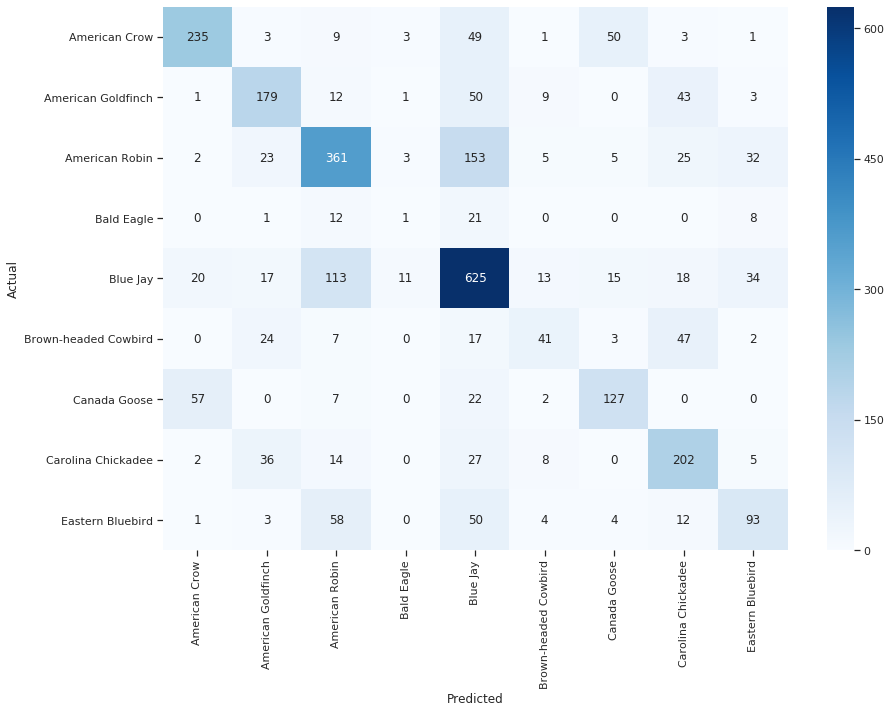

(array([[235,   3,   9,   3,  49,   1,  50,   3,   1],
        [  1, 179,  12,   1,  50,   9,   0,  43,   3],
        [  2,  23, 361,   3, 153,   5,   5,  25,  32],
        [  0,   1,  12,   1,  21,   0,   0,   0,   8],
        [ 20,  17, 113,  11, 625,  13,  15,  18,  34],
        [  0,  24,   7,   0,  17,  41,   3,  47,   2],
        [ 57,   0,   7,   0,  22,   2, 127,   0,   0],
        [  2,  36,  14,   0,  27,   8,   0, 202,   5],
        [  1,   3,  58,   0,  50,   4,   4,  12,  93]]),
 Index(['American Crow', 'American Goldfinch', 'American Robin', 'Bald Eagle',
        'Blue Jay', 'Brown-headed Cowbird', 'Canada Goose',
        'Carolina Chickadee', 'Eastern Bluebird'],
       dtype='object', name='Predicted'))

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_confusion_matrix

def MakeConfusionMatrix( y_test, y_pred ):
    data = {'y_Actual':   y_test,
            'y_Predicted': y_pred
            }

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

    print( confusion_matrix.shape )
    confusion_matrix = confusion_matrix[:-1]
    print( confusion_matrix.shape )
    confusion_matrix.drop(columns=['All'], inplace=True)


    plt.figure(figsize=(14,10))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    '''disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=True)'''
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    return confusion_matrix

confusion_matrix = MakeConfusionMatrix( y_test, y_pred )
confusion_matrix.values, confusion_matrix.columns

[[0.66384181 0.00847458 0.02542373 0.00847458 0.13841808 0.00282486
  0.14124294 0.00847458 0.00282486]
 [0.0033557  0.60067114 0.04026846 0.0033557  0.16778523 0.03020134
  0.         0.1442953  0.01006711]
 [0.00328407 0.03776683 0.59277504 0.00492611 0.25123153 0.00821018
  0.00821018 0.0410509  0.05254516]
 [0.         0.02325581 0.27906977 0.02325581 0.48837209 0.
  0.         0.         0.18604651]
 [0.02309469 0.01963048 0.13048499 0.01270208 0.72170901 0.01501155
  0.01732102 0.02078522 0.03926097]
 [0.         0.17021277 0.04964539 0.         0.12056738 0.29078014
  0.0212766  0.33333333 0.0141844 ]
 [0.26511628 0.         0.03255814 0.         0.10232558 0.00930233
  0.59069767 0.         0.        ]
 [0.00680272 0.12244898 0.04761905 0.         0.09183673 0.02721088
  0.         0.68707483 0.0170068 ]
 [0.00444444 0.01333333 0.25777778 0.         0.22222222 0.01777778
  0.01777778 0.05333333 0.41333333]]
Normalized confusion matrix
Confusion matrix, without normalization


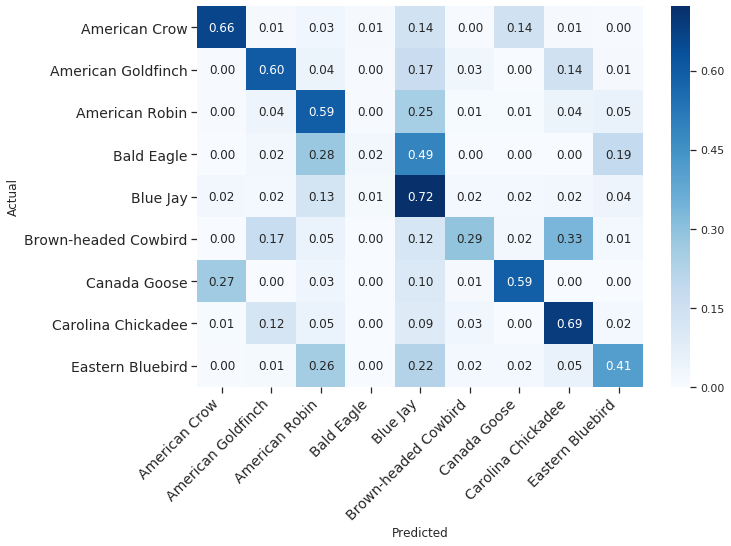

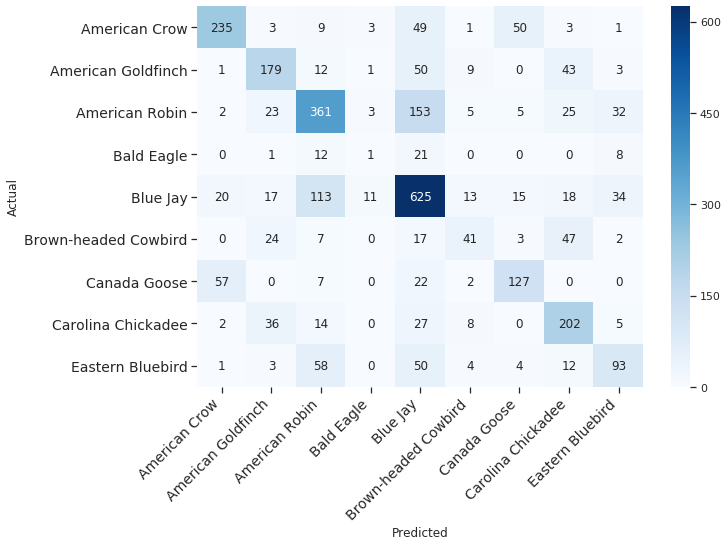

In [42]:
#modified from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, normalize=False, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print(confusion_matrix)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fmt = '.2f' if normalize else 'd'
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, cmap='Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return fig

confusion_matrix = MakeConfusionMatrix( y_test, y_pred )
print_confusion_matrix(confusion_matrix.values, confusion_matrix.columns, normalize=True);
print_confusion_matrix(confusion_matrix.values, confusion_matrix.columns);

In [36]:
dfin = []
for feat,imp in zip(data.columns, cbg.feature_importances_):
    print(feat.strip(), '{:.3f}'.format(imp) )
    dfin.append( (feat.strip(), '{:.3f}'.format(imp)) )
df = pd.DataFrame(dfin)
df.columns = 'features', 'importance'
#df.set_index('features', drop=True, inplace=True)
df

peak_Hz 0.105
peak_Q 0.104
peak_mel 0.121
fourier_freq 0.112
ampmax_n3 0.055
ampmax_n2 0.059
ampmax_n1 0.080
ampmax_0 0.165
ampmax_p1 0.099
ampmax_p2 0.092
num_samples 0.003
sample_rate 0.005


,features,importance
0,peak_Hz,0.105
1,peak_Q,0.104
2,peak_mel,0.121
3,fourier_freq,0.112
4,ampmax_n3,0.055
5,ampmax_n2,0.059
6,ampmax_n1,0.080
7,ampmax_0,0.165
8,ampmax_p1,0.099
9,ampmax_p2,0.092


In [37]:
cbg.classes_.shape

(9,)

In [38]:
i = 20
for i in range(20):
    single = X_test[i].reshape(1,-1) 
    single_ans = y_test[i]

    ab = cbg.predict( single )
    probas = cbg.predict_proba( single )
    #log_probas = cbg.predict_log_proba( single )

    top_results = sorted( zip( cbg.classes_, probas[0] ), key=lambda l: l[1], reverse=True )


    print( f'actual {y_test[i]}, predicted {ab}, top_proba=predicted? {ab[0]==top_results[0][0]}' )
    for res in zip(  top_results[:3]  ):
        print(res)
    print()
    

actual American Crow, predicted ['American Crow'], top_proba=predicted? True
(('American Crow', 0.4757024569885601),)
(('Canada Goose', 0.47451743336062807),)
(('Blue Jay', 0.026449151613487223),)

actual American Robin, predicted ['American Robin'], top_proba=predicted? True
(('American Robin', 0.60342527933599),)
(('Blue Jay', 0.3511780004596037),)
(('Eastern Bluebird', 0.02071876127169588),)

actual American Goldfinch, predicted ['American Goldfinch'], top_proba=predicted? True
(('American Goldfinch', 0.8904439068658291),)
(('Carolina Chickadee', 0.0526571776707669),)
(('American Robin', 0.02848620027915369),)

actual American Crow, predicted ['Canada Goose'], top_proba=predicted? True
(('Canada Goose', 0.6371064893395197),)
(('American Crow', 0.3063642708614631),)
(('Blue Jay', 0.03056707433561996),)

actual American Robin, predicted ['American Goldfinch'], top_proba=predicted? True
(('American Goldfinch', 0.608614123917023),)
(('Brown-headed Cowbird', 0.1620058613781923),)
(('Amer

In [39]:
#best params found on development set

best_params = {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 10, 'subsample': 0.9}

In [ ]:
#compare default with best params found from hyper paramter tuning
cbg = GradientBoostingClassifier( **best_params )
cbg.fit(X_train, y_train)

y_pred = cbg.predict(X_test)
cbg.score(X_test, y_test)

In [ ]:
#f1 scores for 'best' values
GetF1Scores( y_test, y_pred )

sensitivity and specificity, prescision recall, -> short blub about what it says __ talk about two that people ususally use...how well it can predict.  how good is it at false discovery 

roc curve, what youd like to see goes stainght up then stairght down

get rid of bottom row...

reason of why XGboost...why did i choose it

Export the model parameters to feed into the App

In [ ]:
#write the resulting model parameters with joblib
from joblib import dump, load
dump(cbg, 'cbg_model.joblib') 
#test the loading of the model to verify it's functionality
cbg_loaded = load('cbg_model.joblib') 

In [ ]:
#cbg.fit(X_train, y_train)

y_pred = cbg_loaded.predict(X_test)
cbg_loaded.score(X_test, y_test)

In [ ]:
from sklearn.metrics import classification_report
print( classification_report(y_true, y_pred ) )

In [ ]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo', gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

tuned_parameters = [ {'kernel': ['rbf'], 'gamma': [1e-3],# 1e-4],
                      'C': [1, 10]},#, 100, 1000]},
                     {'kernel': ['linear'], 'C': [1, 10]}]#, 100, 1000]} ]

scores = ['precision', 'recall']

for score in scores:
    print(f'# Tuning hyper-parameters for {score}\n')
    
    clf = GridSearchCV(
        svm.SVC(), tuned_parameters, scoring=f'{score}_macro', n_jobs=-1 )
    clf.fit( X_train, y_train )
    print('best params found on development set\n')
    print( clf.best_params_ )
    print('\ngrid scores on development set:\n')
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean,std,params in zip( means, stds, clf.cv_results_['params'] ):
        print('{:.3f} +/-{:.3f} for {}'.format( mean, 2*std, params) )
        print('classification report:\n')
        y_true, y_pred = y_test, clf.predict( X_test )
        print( classification_report(y_true, y_pred ) )
    break

In [ ]:
for mean,std,params in zip( means, stds, clf.cv_results_['params'] ):
        print('{:.3f} +/-{:.3f} for {}'.format( mean, 2*std, params) )
        print('classification report:\n')
        y_true, y_pred = y_test, clf.predict( X_test )
        print( classification_report(y_true, y_pred ) )

take the ratio for the 'all' row and column for each species, to determine the percentage of each species that was predicted corretly
- if it is over 1, then it was 'over-fitted' to that species (i.e. it predicted that species more that there actually were'
- if it is less, then (i would think) this is better since it just mis-identified things and not thought everything was just "a blue jay" because the data set was mostly bue jays

In [ ]:
#tn, tp are diagonals
#fp = top predicted true, but actually false
#fn = predicted false, but actually true
#tn,fp,fn,tp = confusion_matrix.ravel()
CM = np.array(confusion_matrix)
tnfp = CM.ravel()
tp = 0
n = 0
fp = 0
fn = 0
print(CM.shape)
for i,row in enumerate(CM):
    for j,col in enumerate(row):
        n += col
        #print(i,j, CM[i][j], col)
        if i==j:
            tp += col #CM[i][j]
        if i>j:
            fn += col
        if i<j: fp += col

            
#confusion_matrix.all
tp, n, fp, fn

In [ ]:
#hyperparameter tuning for gradient boost classifier
#modified from  https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
#and 
tuned_parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

#score on prescision and recall...
#clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

scores = ['precision', 'recall']

for score in scores:
    print(f'# Tuning hyper-parameters for {score}\n')
    #using macro scoring...try weighted after? ...for micro, prescision=acuracy...for multiclass
    clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring=f'{score}_macro', cv=10, n_jobs=-1)
    #clf = GridSearchCV( svm.SVC(), tuned_parameters, scoring=f'{score}_macro' )
    clf.fit( X_train, y_train )
    print('best params found on development set\n')
    print( clf.best_params_ )
    print('\ngrid scores on development set:')
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean,std,params in zip( means, stds, clf.cv_results_['params'] ):
        print('{:.3f} +/-{:.3f} for {}'.format( mean, 2*std, params) )
        print('classification report:\n')
        y_true, y_pred = y_test, clf.predict( X_test )
        print( classification_report(y_true, y_pred ) )

In [ ]:
CM = multilabel_confusion_matrix(y_test, y_pred)

In [ ]:
import xgboost as xgb
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(x_train, y_train)
model.score(x_test,y_test)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
#multilabel_confusion_matrix(y_test, y_predicted)  #give error due to continous output of RF regressor
y_pred = (y_predicted > 0.5) 
CM = multilabel_confusion_matrix(y_test, y_pred)
#CM = confusion_matrix(y_test, y_pred)
#CMml, CMml.shape
plt.figure()
sn.heatmap(CM[:,:,1], annot=True)
plt.tight_layout()

plt.figure()

sn.heatmap(CM[:,:,0], annot=True)
plt.tight_layout()
CM.shape, CM[:,:,0]
#sn.heatmap(CM, annot=True)
pd.DataFrame(y_pred).head()

In [ ]:
from sklearn.multioutput import MultiOutputRegressor


regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=1000, max_depth=max_depth, random_state=12))
regr_multirf.fit(X_train, y_train)
regr_multirf.score(X_test, y_test)

In [ ]:
label_one = ('zero', 'one')
label_two = ohe_column_names
cols = pd.MultiIndex.from_product([label_one, label_two])

pd.DataFrame(CM.T.reshape(2, -1), columns=cols)

In [ ]:
import seaborn as sn
#get the prediction results
y_predicted = regr_rf.predict(X_test)
#store the actual answers and the predicted answers in a DataFrame
prediction_data = {'y_Actual':   y_test,
        'y_Predicted': y_predicted }

df = pd.DataFrame( y_predicted, y_test )
#df = pd.DataFrame(prediction_data)#, columns=['y_Actual','y_Predicted'])
#calculate the confusion matrix
##confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

#plot the heatmap using seaborn
##sn.heatmap(confusion_matrix, annot=True)
#df = pd.DataFrame(prediction_data, columns=['y_Actual','y_Predicted'])
#y_test
df

In [ ]:
#ratio of species in train vs test (ideally should be ~3 for all)
train, test = pd.DataFrame( y_train ), pd.DataFrame( y_test )
train.columns, test.columns = ['species'], ['species']
train.species.value_counts()/test.species.value_counts(), test.species.value_counts()


In [ ]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, y_train)
clf.score(X_test, y_test)


In [ ]:
predicted = regr_rf.predict(X_test)
for i,prediction in enumerate(predicted):
    print(i, y_test[i] - prediction)
    #print( sum(y_test[i] - prediction))

In [ ]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

a = ((-1, 1, 2, 'a'),
     (3, 4, 2, 'b'),
     (6, 7, 3, 'c'),
     (9, 10, 3, 'd'))

df = pd.DataFrame( a )
df.columns = 'first second third letters'.split()
g_works = sns.pairplot(df)
g_broken = sns.pairplot(df, hue="letters")